In [1]:
import joblib
import pandas as pd
import numpy as np
import logging

FORMAT = "%(asctime)s %(message)s"
logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")


def load_data():
    try:
        path = "/Users/edeno/Downloads/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)
    except FileNotFoundError:
        path = "/cumulus/edeno/non_local_paper/notebooks/"
        position_info = pd.read_pickle(path + "Jaq_03_16_position_info.pkl")
        spikes = pd.read_pickle(path + "Jaq_03_16_spikes.pkl")
        is_ripple = pd.read_pickle(path + "Jaq_03_16_is_ripple.pkl")
        env = joblib.load(path + "Jaq_03_16_environment.pkl")

        time = np.asarray(position_info.index / np.timedelta64(1, "s"))
        spikes = np.asarray(spikes).astype(float)
        position = np.asarray(position_info.linear_position).astype(float)
        position2D = np.asarray(position_info[["nose_x", "nose_y"]]).astype(float)
        is_ripple = np.asarray(is_ripple).squeeze()
        speed = np.asarray(position_info.nose_vel).astype(float)

    return is_ripple, spikes, position, speed, env, time, position2D

In [2]:
import jax
import pprint

pprint.pprint(jax.devices())

2023-06-26 15:31:36.748876: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 0 and 9; status: INTERNAL: failed to enable peer access from 0x7f6b94624bd0 to 0x7f6b8c638b50: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 15:31:36.750604: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 1 and 9; status: INTERNAL: failed to enable peer access from 0x7f6b88625590 to 0x7f6b8c638b50: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 15:31:36.751884: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 2 and 9; status: INTERNAL: failed to enable peer access from 0x7f6b9c625100 to 0x7f6b8c638b50: CUDA_ERROR_TOO_MANY_PEERS: peer mapping resources exhausted
2023-06-26 15:31:36.752967: W external/xla/xla/pjrt/gpu/gpu_helpers.cc:63] Unable to enable peer access between GPUs 3 and 9; status: INTERNAL: failed to enable peer access from 0x7f6b

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=4, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=5, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=6, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=7, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=8, process_index=0, slice_index=0),
 StreamExecutorGpuDevice(id=9, process_index=0, slice_index=0)]


In [3]:
device_id = 1
device = jax.devices()[device_id]
jax.config.update("jax_default_device", device)
device

StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0)

In [4]:
is_ripple, spikes, position, speed, env, time, position2D = load_data()

26-Jun-23 15:31:38 Cupy is not installed or GPU is not detected. Ignore this message if not using GPU
/home/edeno/miniconda3/envs/non_local_detector_gpu/lib/python3.10/site-packages/replay_trajectory_classification/likelihoods/multiunit_likelihood.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [5]:
from non_local_detector import NonLocalSortedSpikesDetector

detector = NonLocalSortedSpikesDetector(
    sorted_spikes_algorithm="sorted_spikes_kde",
    sorted_spikes_algorithm_params={
        "position_std": 6.0,
        "use_diffusion": False,
        "block_size": 8000,
        "interpolate_local": False,
    },
).fit(position2D, spikes, is_training=~is_ripple)

26-Jun-23 15:31:40 Fitting initial conditions...
26-Jun-23 15:31:40 Fitting discrete state transition
26-Jun-23 15:31:40 Fitting continuous state transition...
26-Jun-23 15:31:42 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

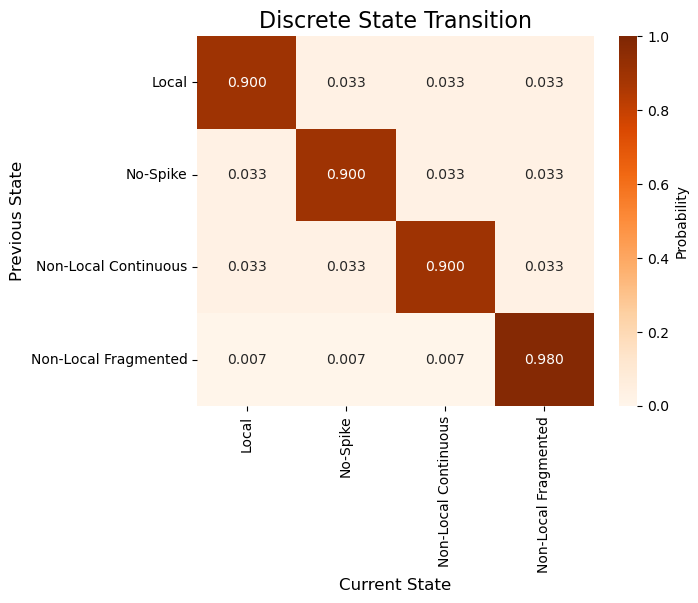

In [6]:
detector.plot_discrete_state_transition()

In [7]:
results = detector.predict(spikes, position2D, time=time)
results

26-Jun-23 15:32:07 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:35:06 Computing posterior...
26-Jun-23 15:35:31 Finished computing posterior...


<xarray.Dataset>
Dimensions:                      (time: 452325, state_bins: 6946, states: 4,
                                  state_ind: 6946)
Coordinates:
  * time                         (time) float64 2.239e+04 ... 2.329e+04
  * state_bins                   (state_bins) object MultiIndex
  * state                        (state_bins) object 'Local' ... 'Non-Local F...
  * x_position                   (state_bins) float64 nan nan ... 119.0 121.0
  * y_position                   (state_bins) float64 nan nan ... 108.3 108.3
  * state_ind                    (state_ind) int64 0 1 2 2 2 2 2 ... 3 3 3 3 3 3
  * states                       (states) <U20 'Local' ... 'Non-Local Fragmen...
    environments                 (states) <U1 '' '' '' ''
    encoding_groups              (states) int64 0 0 0 0
Data variables:
    acausal_posterior            (time, state_bins) float32 1.0 0.0 ... nan nan
    acausal_state_probabilities  (time, states) float64 1.0 0.0 0.0 ... 0.0 0.0
Attributes:
    marginal_log_likelihoods:  -1970902.5

In [8]:
results = detector.estimate_parameters(spikes, position2D, time=time)

26-Jun-23 15:35:56 Fitting initial conditions...
26-Jun-23 15:35:56 Fitting discrete state transition
26-Jun-23 15:35:56 Fitting continuous state transition...
26-Jun-23 15:35:58 Fitting place fields...


Encoding models:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:36:19 Computing log likelihood...


Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

Non-Local Likelihood:   0%|          | 0/104 [00:00<?, ?cell/s]

26-Jun-23 15:39:08 Expectation step...
26-Jun-23 15:39:08 Computing posterior...
26-Jun-23 15:39:33 Finished computing posterior...
26-Jun-23 15:39:33 Maximization step..
26-Jun-23 15:39:33 Computing stats..
26-Jun-23 15:39:33 iteration 1, likelihood: -1961605.625
26-Jun-23 15:39:33 Expectation step...
26-Jun-23 15:39:33 Computing posterior...
26-Jun-23 15:39:57 Finished computing posterior...
26-Jun-23 15:39:57 Maximization step..
26-Jun-23 15:39:57 Computing stats..
26-Jun-23 15:39:58 iteration 2, likelihood: -1925712.625, change: 35893.0
26-Jun-23 15:39:58 Expectation step...
26-Jun-23 15:39:58 Computing posterior...
26-Jun-23 15:40:22 Finished computing posterior...
26-Jun-23 15:40:22 Maximization step..
26-Jun-23 15:40:22 Computing stats..
26-Jun-23 15:40:22 iteration 3, likelihood: -1926910.375, change: -1197.75
26-Jun-23 15:40:22 Expectation step...
26-Jun-23 15:40:22 Computing posterior...
26-Jun-23 15:40:46 Finished computing posterior...
26-Jun-23 15:40:46 Maximization step..

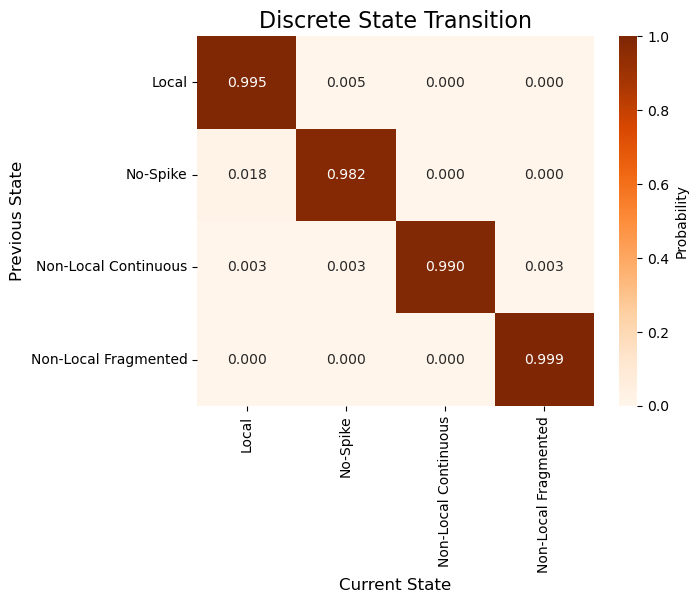

In [9]:
detector.plot_discrete_state_transition()